In [1]:
""" Resize the notbook to full width, to fit more code and images """
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
""" some basic packages and settings to show images inline """
import numpy as np
import importlib
%matplotlib inline
import matplotlib.pyplot as plt
""" automatically reload included modules (need to run import command to trigger reloading) """
%load_ext autoreload
%autoreload 2
""" Controls for figure sizes to change """
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams.update({'errorbar.capsize': 1})

from triplet import *

Using device: cpu


## Retrieval

In [2]:
net = load_net('./models/net_class.pl') # load pretrained classification network
# net = load_net('./models/net_triplet.pl') # load pretrained classification network

# qery test images, use all test set to retrive
torch.manual_seed(0)
loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=True, num_workers=0)
loader_iterator = iter(loader)
queries, qlabels = next(loader_iterator)
#

In [3]:
n_queries = len(queries)
queries_features = net.features(queries)

In [4]:
import heapq as hq

from dataclasses import dataclass, field
from typing import Any

@dataclass(order=True)
class PrioritizedItem:
    priority: float
    item: Any=field(compare=False)

closest_features = [[PrioritizedItem(0.0, queries[i])] for i in range(n_queries)]

for x,l in loader_iterator:
    out = net.features(x)
    dists = distances(out, queries_features)
    min_dists, q_idxs = torch.min(dists, dim=1)

    for x_idx, (min_dist, q_idx) in enumerate(zip(min_dists, q_idxs)):
        item = PrioritizedItem(min_dist.item(), x[x_idx])
        hq.heappush(closest_features[q_idx.item()], item)


<Figure size 3200x800 with 0 Axes>

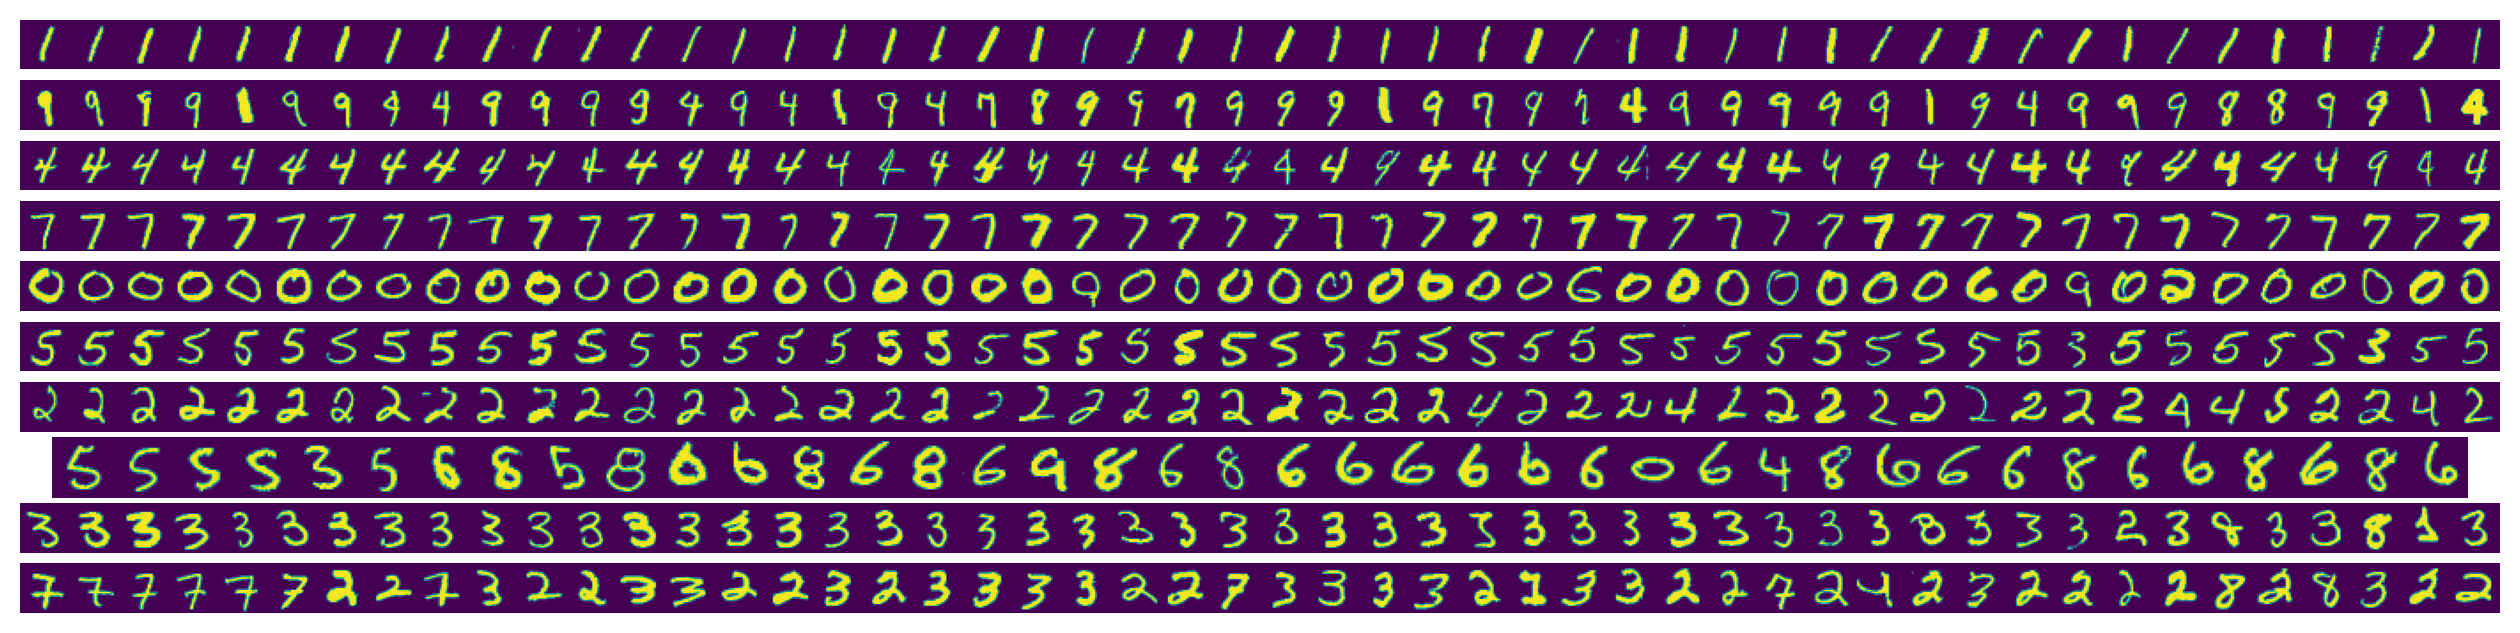

In [5]:
plt.clf()
f, axarr = plt.subplots(n_queries, 1, gridspec_kw = {'wspace':0, 'hspace':0})

for i in range(len(queries)):
    ax = axarr[i]

    img = torch.concat([item.item for item in hq.nsmallest(50, closest_features[i])], dim=2)
    ax.imshow(img.cpu().numpy().transpose(1, 2, 0))
    ax.axis('off')

............................................................X..XX.X.X....XX.XXXXX..X....XXX.X..XXX..
..........................X.X...X........X.X.......XXX.X.XXXXXXXXXXX..XXXXX.XX.X...X.XXXXXXXX.X.X.X.
....X.XXXXXXX.X.X.XXX.X.XXX.X..X.XXX.XXXXXXX.X..XXXX.XX.XX.XXXXXX.XXXXXX..XXXXXXXXX..X.XXXX..X.XXX.X
..........................X................X.......X...X...X..X..XX.XXXXXXXX.XXXXX..X.X.XX.XX.X.XXXX
.........................................X....................XXX.XX...XX.XXX.X.XX....XX.XX..XXX.XXX
....X.XX..X..XXX..X.XX.X..XXXXXXXXXXXXXXXX.XXXXXXX.XXXXXXXXXX.XXXXXXXXXXXXXXXXXXXXXXXXXXXX.X.XXXXXXX
.................................X........X.XX......X.......XXX.....XXX...X.XX..XXXXX.XXX.XXXXXX.XX.
.......................................X...X...X..XXXX.X....X...X..X.X...X.X.XX..XXXXX.XXX.XXXX.X.XX
........X.......X..X...XX.....X.X.XX.X.X.XXX.XX....XXXX...X.XXXXXX.XX.X..XX.XX..XXXXXX.XXX.XXX.XXXXX
..............................................................................X..X........X

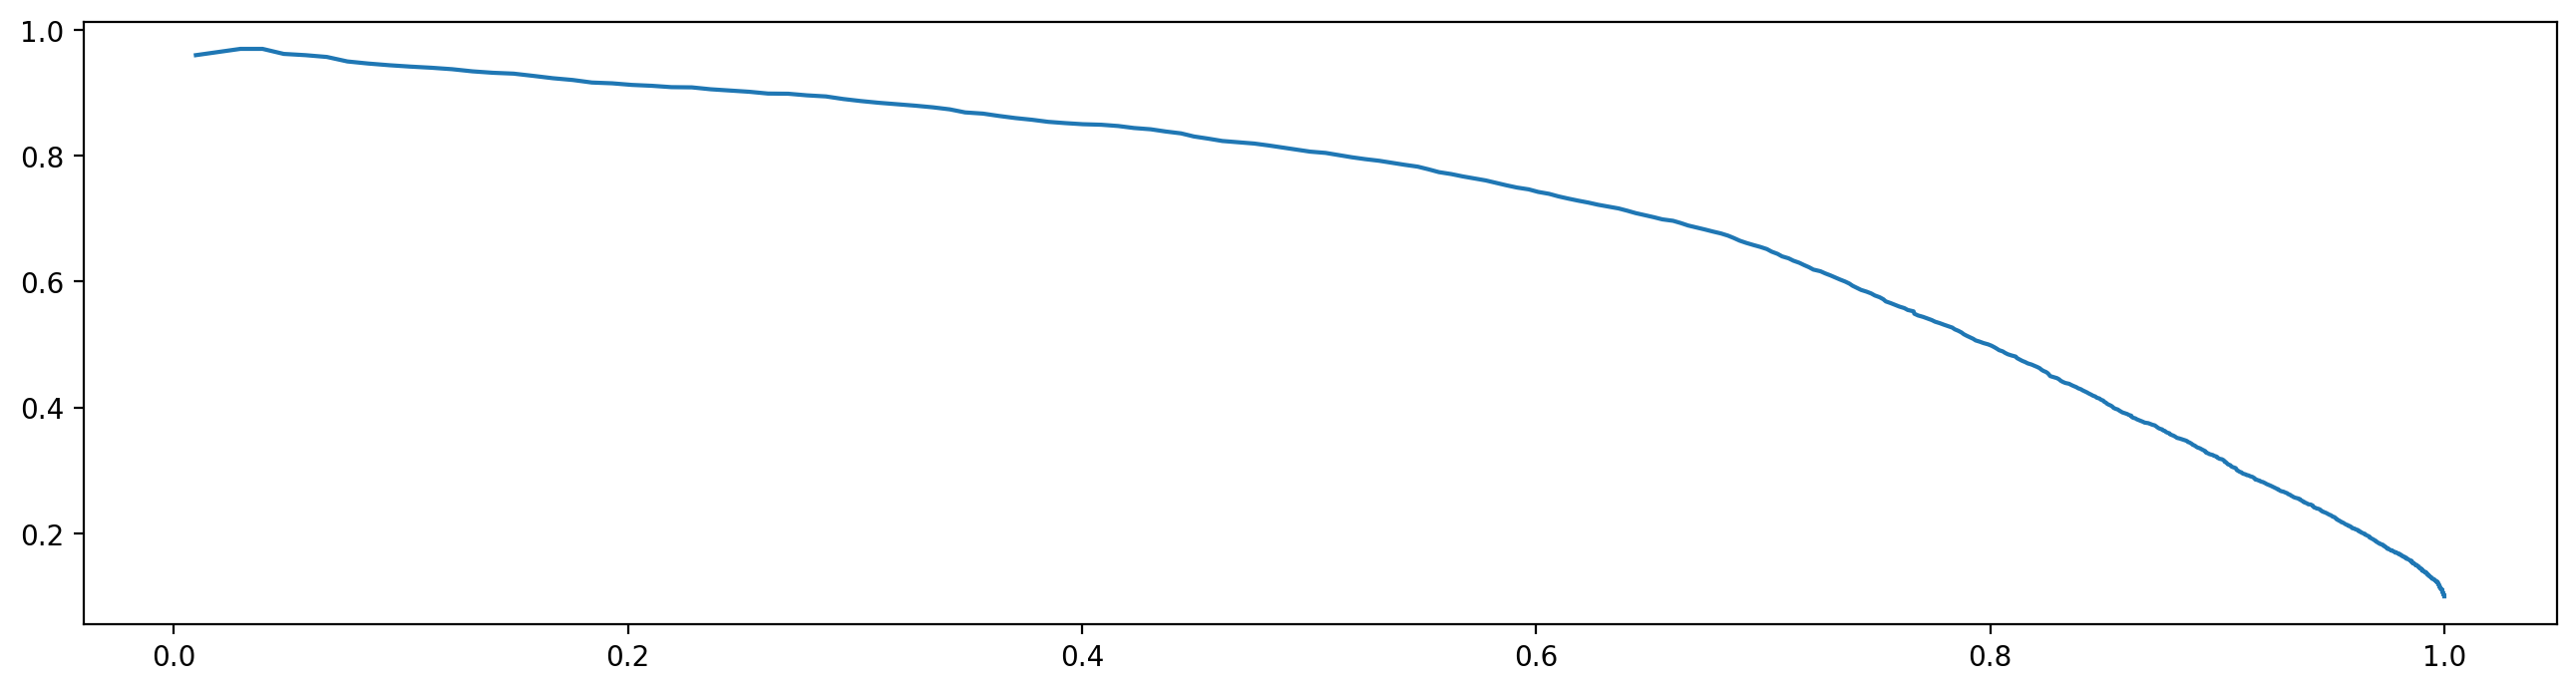

In [6]:
mAP, mPrec, mRec = evaluate_mAP(net, test_set)
print(f"{mAP = }")

""" Plot Precision vs. Recall"""
plt.plot(mRec, mPrec)

# Part 2. Metric Learning

In [38]:
net_triplet = new_net()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
train_triplets(net_triplet, train_loader,100)

Using device: cpu
epoch 0 trn loss 130.70086669921875
epoch 1 trn loss 101.76536560058594
epoch 2 trn loss 63.75181198120117
epoch 3 trn loss 83.04955291748047
epoch 4 trn loss 68.38452911376953


................................X........X.....X..X...X..XX..X.....X.X.XX..XXXXXXX.XX..XXXX.XX.X..X.
..........................................X...X..X....X..XXXX.X...XX....X............XX.X..XX.X..XXX
X...X.X.X..X....X...XX.X..X.X...XXXX.XXX.X..XXXXXXX.X.XXXXXXX.XXX.XX.XXXXXX.XXX.XX.XXXX.XXX..XXX.XXX
........X.................X..X..X......XXX..X..X.XX..X.XX.XXX.X.XXXX.X.X..X.X.XX...X.XXX.XXX.XXXXX..
...............................................X.....X.......X....XXX......XX.XXX.X.X.X..XXX.X.XXXX.
..X..XX.XXXXXXXXXXXXX.XXX.X.XXXXXXXX.XX.XXX..X..XXX.XXXXXXXXXX.XXX.XXXXXXXXX.XXX.XXXX.XXXXX.XXXXX.XX
.......................................X................X.......X..X...X.X.X....XX..XXX..XXXXXX.XXXX
.......................X........X..............X...XXXXX........X.XXXX..XXXX.XX.X.X.....X.X..XX.XXXX
......X..X.XXXXX..XX.X.X.XXXX..XXXX.XX.X....XX.XX....XXXX.XXXXX...X.XXXXX.XX.XXXXXXXXXXXX.X.XX.X.XXX
......................................................................XXX.XX.....X...X....X

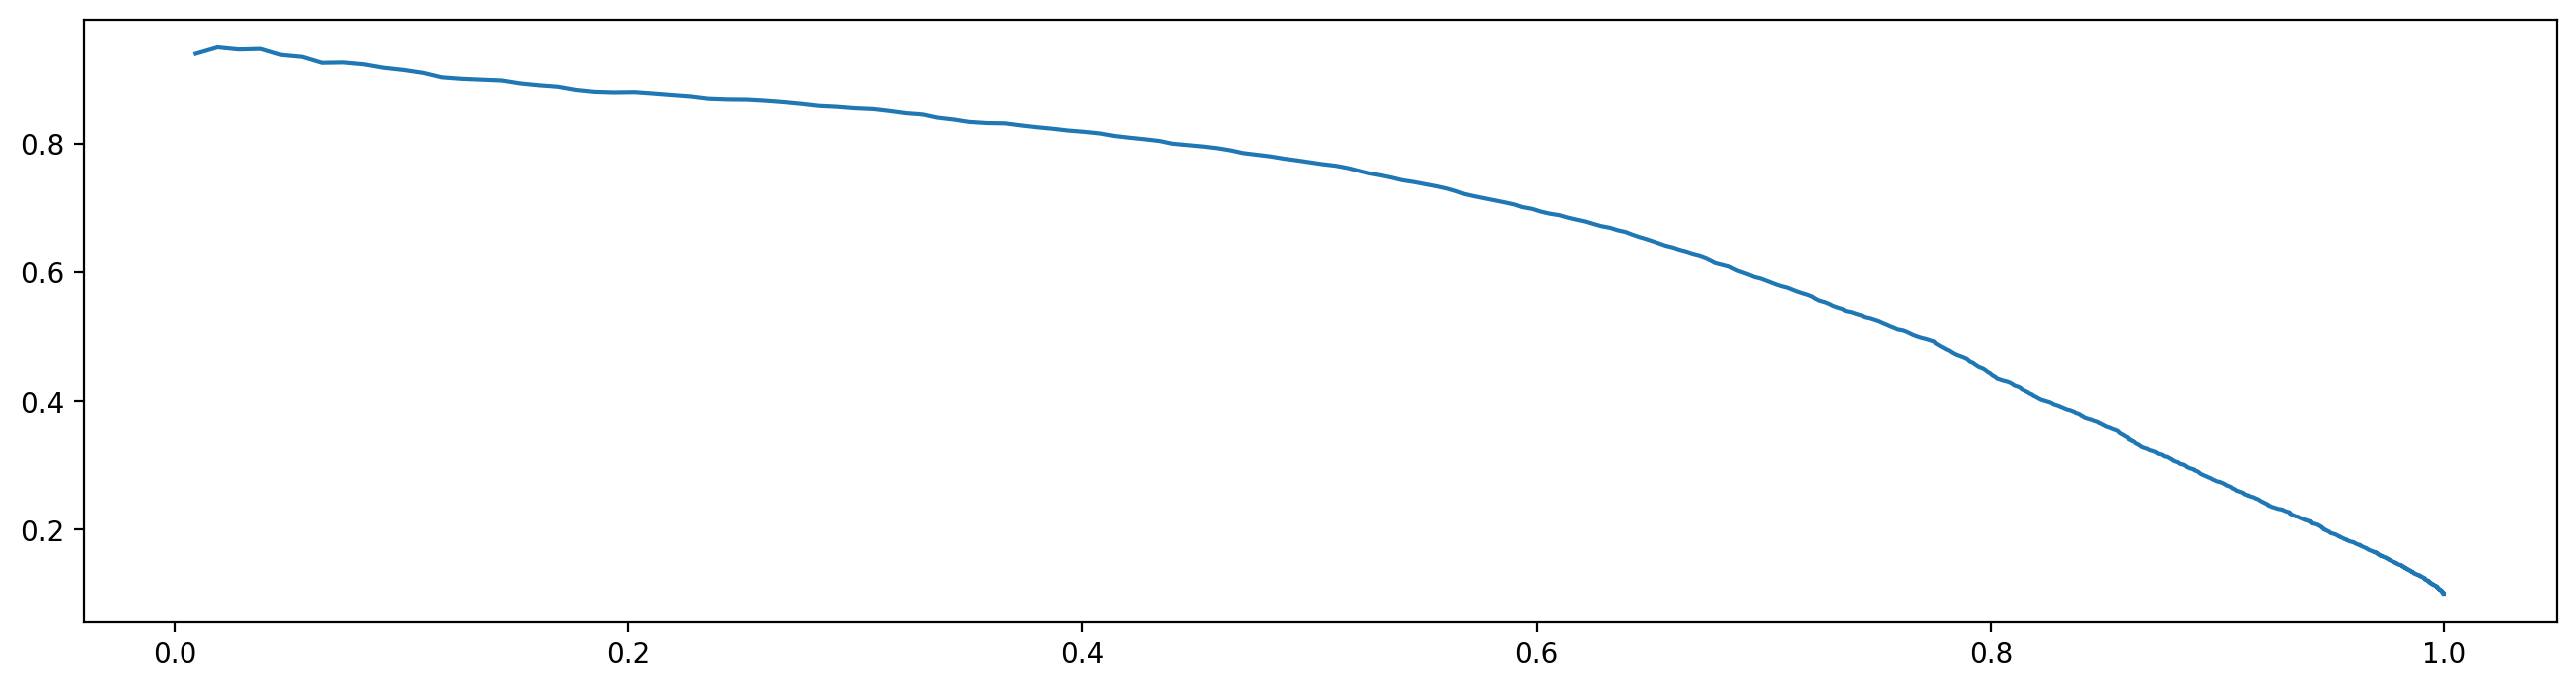

In [39]:
mAP, mPrec, mRec = evaluate_mAP(net_triplet, test_set)
print(f"{mAP = }")

""" Plot Precision vs. Recall"""
plt.plot(mRec, mPrec)